In [1]:
import os
import sys
sys.path.append('/Users/aghavamp/Desktop/Projects/')

import scipy.io as sio
import h5py
import rsatoolbox as rsa
from rsatoolbox.io import spm as spm_io
import matplotlib.pyplot as plt
import getpass
import numpy as np
import pandas as pd
import surfAnalysisPy as surf
import nibabel as nb
import nitools as nt
from matplotlib.cm import ScalarMappable
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from pathlib import Path
import seaborn as sns
import PcmPy as pcm
import glob
import matplotlib.patches as patches


# SET PATHS:
# baseDir = '/Users/alighavam/Desktop/Projects/bimanual_wrist/data/fMRI'
baseDir = os.path.join('/Users', getpass.getuser(), 'Desktop', 'Projects', 'bimanual_wrist', 'data', 'fMRI')
bidsDir = 'BIDS'
anatomicalDir = 'anatomicals'
freesurferDir = 'surfaceFreesurfer'
surfacewbDir = 'surfaceWB' 
behavDir = 'behavioural'
regDir = 'ROI'
atlasDir = '/Volumes/diedrichsen_data$/data/Atlas_templates/fs_LR_32'
analysisDir = os.path.join(os.path.dirname(os.path.dirname(baseDir)), 'analysis')


## Time Series per run

In [9]:
roi_names = ['...._L', '..S1_L', '..M1_L', '.PMd_L', '.PMv_L', '.SMA_L', '..V1_L', 'SPLa_L', 'SPLp_L', 
             '...._R', '..S1_R', '..M1_R', '.PMd_R', '.PMv_R', '.SMA_R', '..V1_R', 'SPLa_R', 'SPLp_R'] # 18 values
glm = 'single'
pre = 8
post = 21
participants = [101,102,103,104,106,107,108]
# participants = [101]

region = 2

def extract_snippets(y, pre, post, onsets):
    snippets_y = []
    
    for onset in onsets:
        onset_frame = np.round(onset).astype(int) # the fMRI volume closest to the onset time
        # onset_frame = np.round(onset).astype(int) - 1  # in python, the index starts from 0, so we need to subtract 1

        start_idx = onset_frame - pre # <pre> volumes before the onset
        end_idx = onset_frame + post # <post> volumes after the onset

        snippet_y = np.full(pre + post + 1, np.nan) # nan fill the snippet
        
        valid_start = int(max(0, start_idx)) # make sure the start index is not negative
        valid_end = int(min(len(y), end_idx + 1)) # make sure the end index is not out of bounds
        
        insert_start = int(valid_start - start_idx) # where to start inserting the data
        insert_end = int(insert_start + (valid_end - valid_start)) # where to end inserting the data

        snippet_y[insert_start:insert_end] = y[valid_start:valid_end] # insert the data into the snippet
        
        snippets_y.append(snippet_y)
            
    return np.array(snippets_y)

timeseries = pd.read_table(os.path.join(analysisDir, 'timeseries_uwo.tsv'))
T = pd.DataFrame()
for sn in participants:
    # load participant info:
    pinfo = pd.read_table(os.path.join(baseDir, 'participants.tsv'))
    numTR = int(pinfo[pinfo['sn']==sn]['numTR'].values[0])
    runs = pinfo[pinfo['sn']==sn]['glm_runs'].values[0]
    runs = [int(run) for run in runs.split('.')]
    
    reginfo = pd.read_table(os.path.join(baseDir, f'glm{glm}', f's{sn}', f'reginfo.tsv'))
    timeseries_sn = timeseries[timeseries.sn==sn].reset_index(drop=True)

    # per run time series for a region:
    y_run_avg = np.zeros(numTR)
    y_hat_avg = np.zeros(numTR)
    for i, run in enumerate(runs):
        rows = (timeseries_sn.region==roi_names[region]) & (timeseries_sn.run==run)
        y_adj = timeseries_sn[rows]['y_adj'].values.flatten()
        y_hat = timeseries_sn[rows]['y_hat'].values.flatten()
        
        t = np.arange(0, numTR, 1)
        ons = reginfo[reginfo.run==run]['ons'].values.flatten() - numTR * (run - 1)
        
        fig, ax = plt.subplots(1, 1, figsize=(20, 4))
        ax.vlines(ons, ymin=min(y_adj), ymax=max(y_adj), colors='b', lw=0.5, alpha=0.5, linestyles='--')
        plt.plot(t, y_hat, color='r', lw=1.5)
        plt.plot(t, y_adj, color='k', lw=1)
        plt.xlabel('time (s)')
        plt.ylabel('y adj')
        plt.xlim((t[0]-2, t[-1]+2))
        plt.title(f'run {run} - glm{glm}, region: {roi_names[region].lstrip(".")}')
        plt.tight_layout()
        plt.savefig(f'../figures/glm{glm}/timeseries/s{sn}_run{run:02d}_{roi_names[region].lstrip(".")}.pdf', bbox_inches="tight")
        plt.close()
        y_run_avg += y_adj/len(runs)
        y_hat_avg += y_hat/len(runs)

    '''
    ||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
    TIME LOCKING AND AVERAGING THE TIME SERIES 
    ||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
    '''
    # load the events:
    reginfo = pd.read_table(os.path.join(baseDir, f'glm{glm}', f's{sn}', f'reginfo.tsv'))
    timeseries_sn = timeseries[timeseries.sn==sn].reset_index(drop=True)
    pinfo = pd.read_table(os.path.join(baseDir, 'participants.tsv'))
    numTR = int(pinfo[pinfo['sn']==sn]['numTR'].values[0])
    runs = pinfo[pinfo['sn']==sn]['glm_runs'].values[0]
    runs = [int(run) for run in runs.split('.')]
    ons = reginfo['ons'].values.flatten()
    cond_names = reginfo['name'].values.flatten()
    
    for r in range(len(roi_names)): # loop over regions
        y_adj = timeseries_sn[timeseries_sn.region==roi_names[r]]['y_adj'].values.flatten()
        y_hat = timeseries_sn[timeseries_sn.region==roi_names[r]]['y_hat'].values.flatten()

        y_adj_cut = extract_snippets(y_adj, pre, post, ons)
        y_hat_cut = extract_snippets(y_hat, pre, post, ons)

        tmp = pd.DataFrame()
        tmp['sn'] = [sn]*len(ons)
        tmp['region'] = [roi_names[r].lstrip('.')]*len(ons)
        tmp['run'] = reginfo['run'].values.flatten()
        tmp['cond_name'] = reginfo['name'].values.flatten()
        tmp['Uni_or_Bi'] = [int('bi' in name) for name in reginfo['name'].values.flatten()]
        tmp['hand'] = [0 if 'lhand' in name else 1 if 'rhand' in name else 2 for name in reginfo['name'].values.flatten()]
        tmp['angle_left'] = [int(name.split(':')[1]) if 'lhand' in name else int(name.split(':')[1].split('_')[0]) if 'bi' in name else -1 for name in reginfo['name'].values.flatten()]
        tmp['angle_right'] = [int(name.split(':')[1]) if 'rhand' in name else int(name.split(':')[1].split('_')[1]) if 'bi' in name else -1 for name in reginfo['name'].values.flatten()]
        tmp['ons'] = reginfo['ons'].values.flatten()
        tmp['ons_diff'] = np.insert(np.diff(ons), 0, -1)
        
        col_names = [f"y_adj{i-pre}" for i in range(y_adj_cut.shape[1])]
        df_y_adj = pd.DataFrame(y_adj_cut, columns=col_names)
        col_names = [f"y_hat{i-pre}" for i in range(y_hat_cut.shape[1])]
        df_y_hat = pd.DataFrame(y_hat_cut, columns=col_names)
        tmp = pd.concat([tmp, df_y_hat], axis=1).reset_index(drop=True)
        tmp = pd.concat([tmp, df_y_adj], axis=1).reset_index(drop=True)

        T = pd.concat([T, tmp], axis=0).reset_index(drop=True)

T.to_csv(os.path.join(analysisDir, f'timeseries_cut_uwo.csv'), index=False)



## Time series time lock to stimulus onset

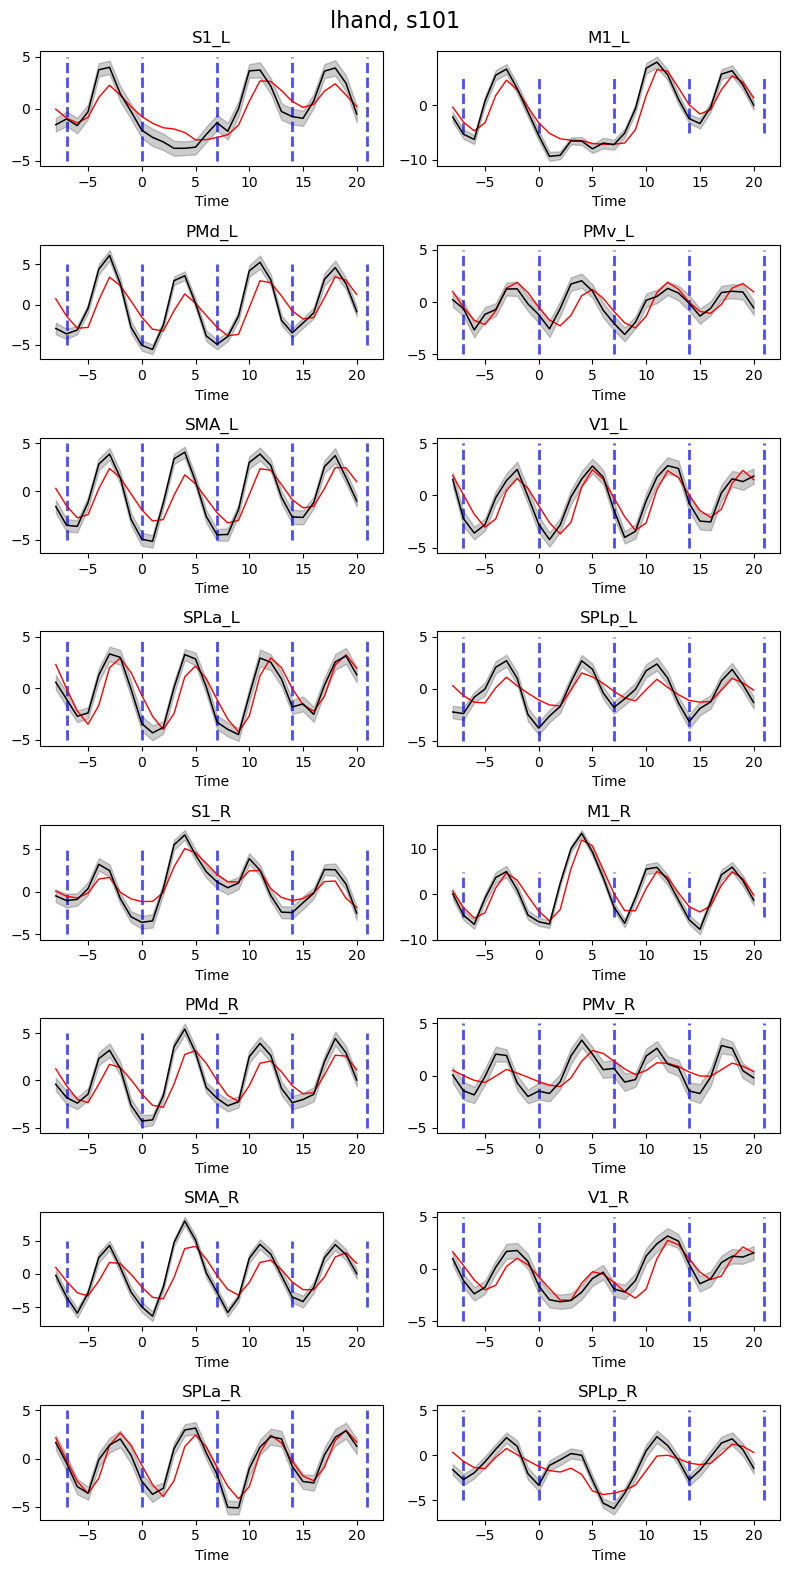

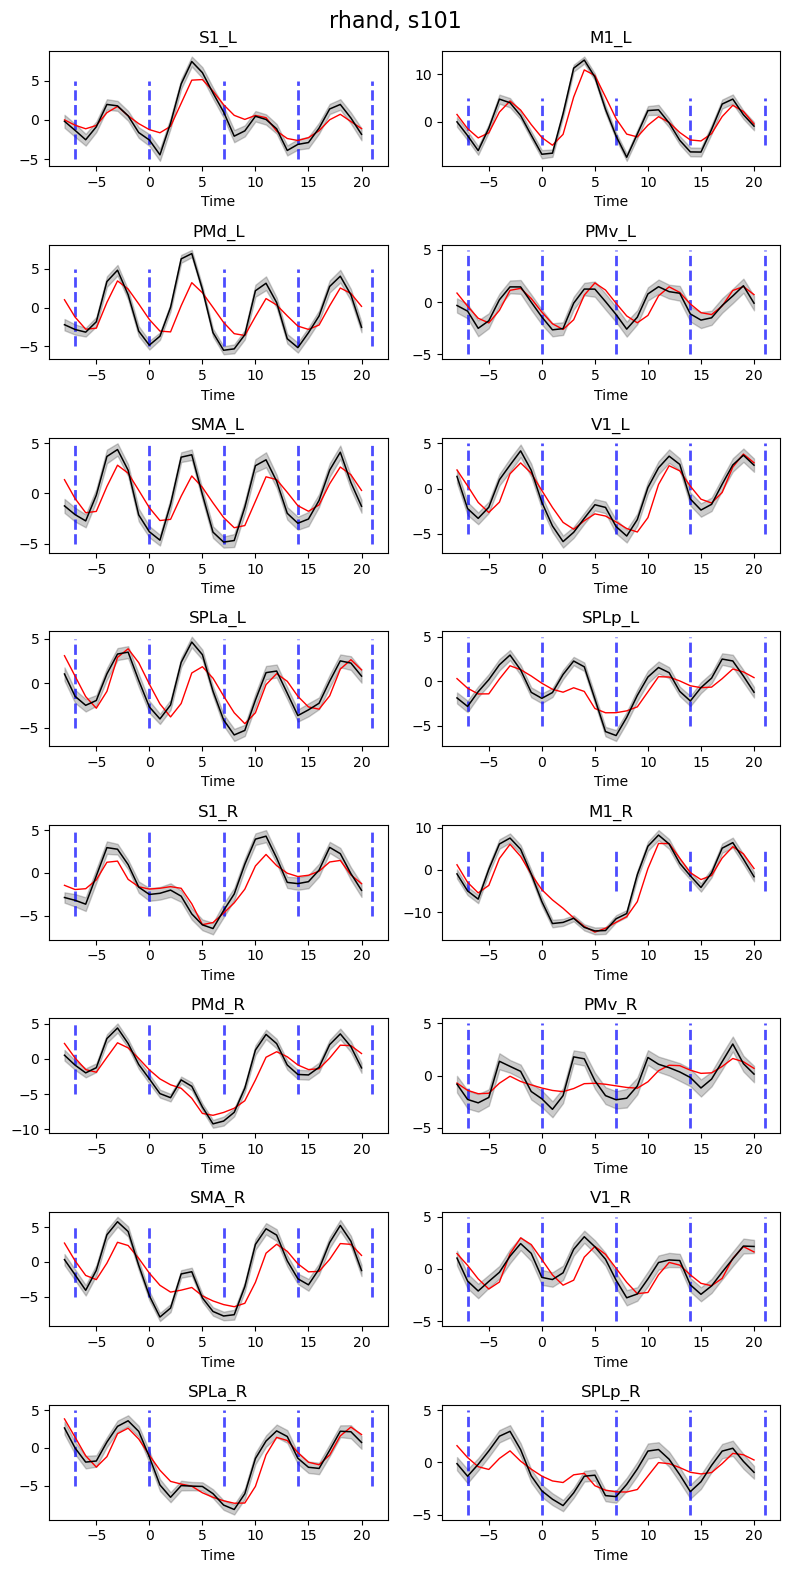

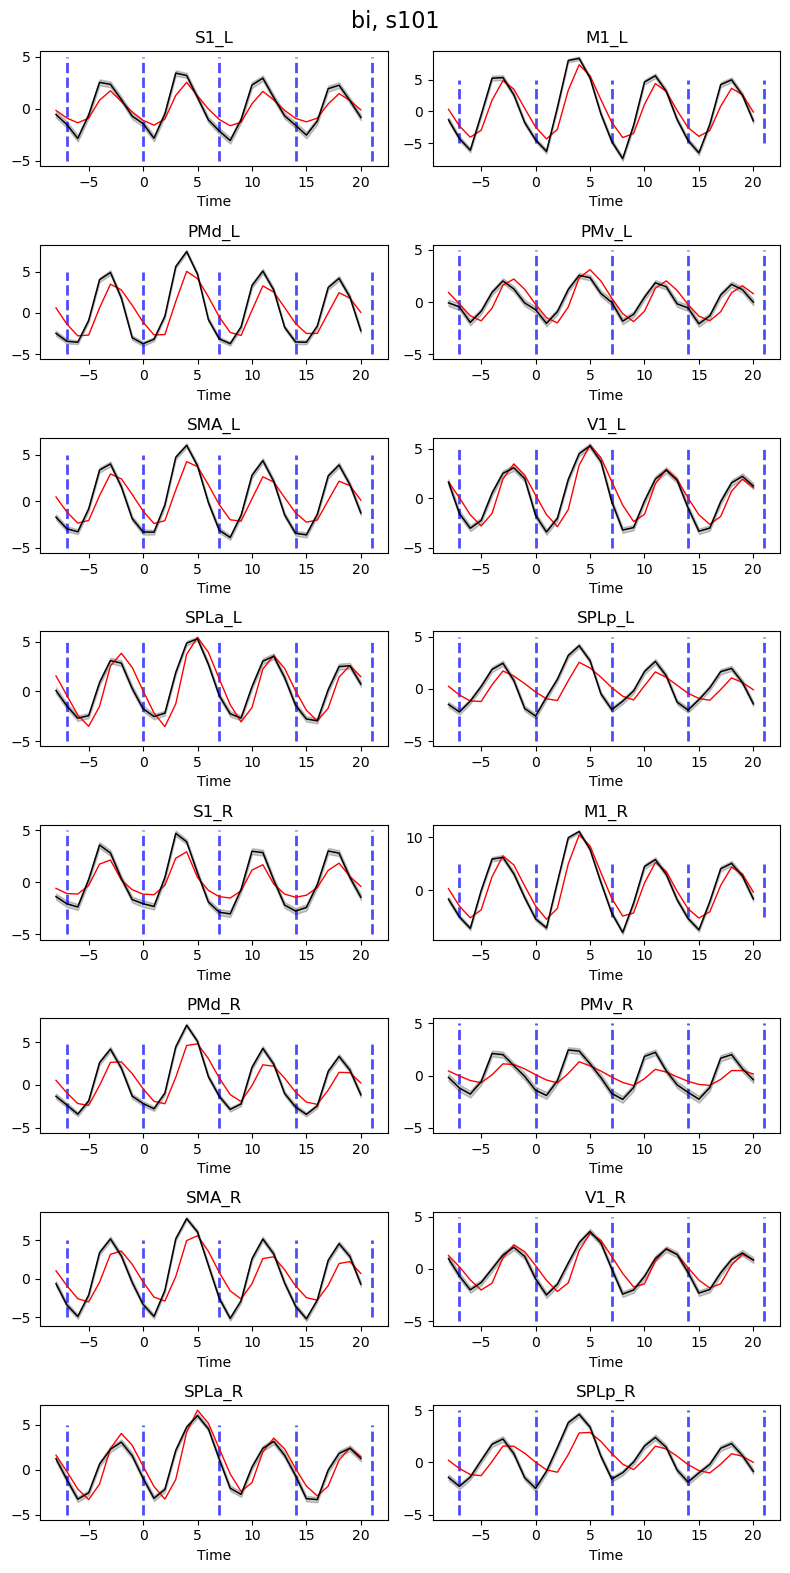

In [14]:
pre = 8
post = 21

participants = [101,102,103,104,106,107,108]
# participants = [101]

conds = ['lhand','rhand','bi']
roi_names = ['S1_L', 'M1_L', 'PMd_L', 'PMv_L', 'SMA_L', 'V1_L', 'SPLa_L', 'SPLp_L', 
             'S1_R', 'M1_R', 'PMd_R', 'PMv_R', 'SMA_R', 'V1_R', 'SPLa_R', 'SPLp_R']

pinfo = pd.read_table(os.path.join(baseDir, 'participants.tsv'))
timeseries = pd.read_csv(os.path.join(analysisDir, f'timeseries_cut_uwo.csv'))
TR = pinfo['TR'].values[0]/1000
t = np.arange(-pre, post, TR)

ymin = -5
ymax = 5
n_row = 8
n_col = 2
for cnt, sn in enumerate(participants):
    T = timeseries[timeseries.sn==sn].reset_index(drop=True)
    for cond in conds:
        fig, axes = plt.subplots(n_row, n_col, figsize=(8, 16))
        for j, r in enumerate(roi_names): # loop over regions
            y_adj = T.loc[(T['region']==r) & (T['cond_name'].str.contains(cond, na=False)), [f'y_adj{i-pre}' for i in range(len(t))]].mean().to_list()
            y_adj_sem = T.loc[(T['region']==r) & (T['cond_name'].str.contains(cond, na=False)), [f'y_adj{i-pre}' for i in range(len(t))]].sem().to_list()

            y_hat = T.loc[(T['region']==r) & (T['cond_name'].str.contains(cond, na=False)), [f'y_hat{i-pre}' for i in range(len(t))]].mean().to_list()

            ax = axes[j//n_col, j%n_col]
            ax.vlines([-7,0,7,14,21], ymin=ymin, ymax=ymax, color='b', ls='--', lw=2, alpha=0.7)
            # ax.vlines([-2,5,12,19], ymin=min(min(y_adj),min(y_hat)), ymax=max(max(y_adj),max(y_hat)), color='k', ls='--', lw=0.4, alpha=0.85)
            ax.plot(t, y_hat, color='r', lw=1)
            ax.plot(t, y_adj, color='k', lw=1.1)
            ax.fill_between(t, np.array(y_adj)-np.array(y_adj_sem), np.array(y_adj)+np.array(y_adj_sem), color='k', alpha=0.2)
            ax.set_title(f'{r}')
            ax.set_xlabel('Time')
        # title for the whole figure
        fig.suptitle(f'{cond}, s{sn}', fontsize=16)
        plt.tight_layout()
        # plt.savefig(f'../figures/time_series/timelock_s{sn}_glm{glm}_{cond}.pdf', bbox_inches="tight")
        if cnt == 0:
            plt.show()
        else:
            plt.close()


## TS timelock for Gap, and Non Gap

In [12]:
glm = 1

pre_idx = 8
post_idx = 21

participants = [101,102,103,104,106,107,108]

conds = ['lhand','rhand','bi']
roi_names = ['_l', 'S1_l', 'M1_l', 'PMd_l', 'PMv_l', 'SMA_l', 'V1_l', 'SPLa_l', 'SPLp_l', 
             '_r', 'S1_r', 'M1_r', 'PMd_r', 'PMv_r', 'SMA_r', 'V1_r', 'SPLa_r', 'SPLp_r']

pinfo = pd.read_table(os.path.join(baseDir, 'participants.tsv'))
df = pd.DataFrame()
for cnt, sn in enumerate(participants):
    T = pd.read_csv(os.path.join(baseDir, regDir, f's{sn}', f'bmw_time_series_cut_glm{glm}.csv'))
    for i, r in enumerate(list(range(1, 9)) + list(range(10, 18))): # loop over regions
        T_sorted = T.loc[T.region==r, :]
        # Sort the DataFrame by BN first, then by TN within each BN
        T_sorted = T_sorted.sort_values(by=['BN', 'TN']).reset_index(drop=True)
        T_sorted['onset_diff'] = T_sorted.groupby('BN')['onset'].diff()
        T_sorted['sn'] = sn
        T_sorted['region_name'] = roi_names[r]
        df = pd.concat([df, T_sorted], axis=0).reset_index(drop=True)

df.to_csv(os.path.join(analysisDir, f'time_series_glm{glm}.csv'), index=False)

# TR = pinfo['TR'].values[0]/1000
# t = np.arange(-pre_idx, post_idx, TR)

# ymin = -0.5
# ymax = 0.5
# n_row = 8
# n_col = 2

    

### plot

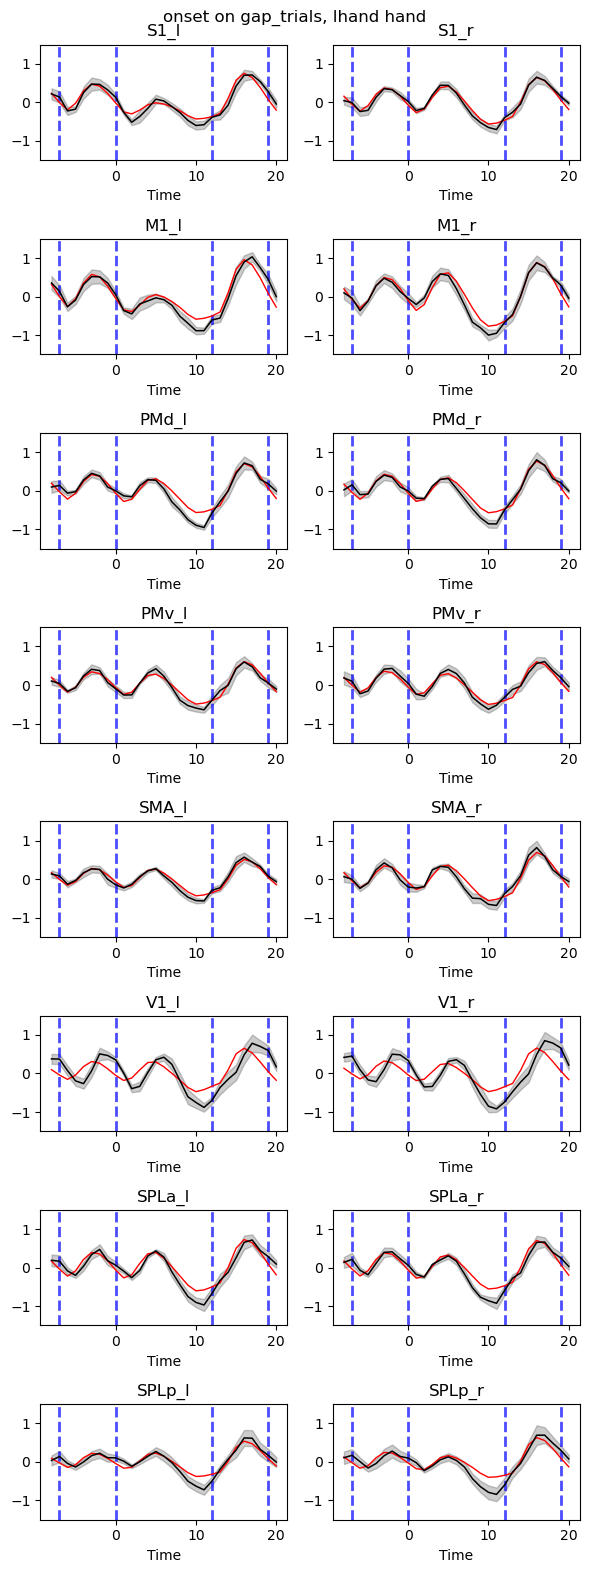

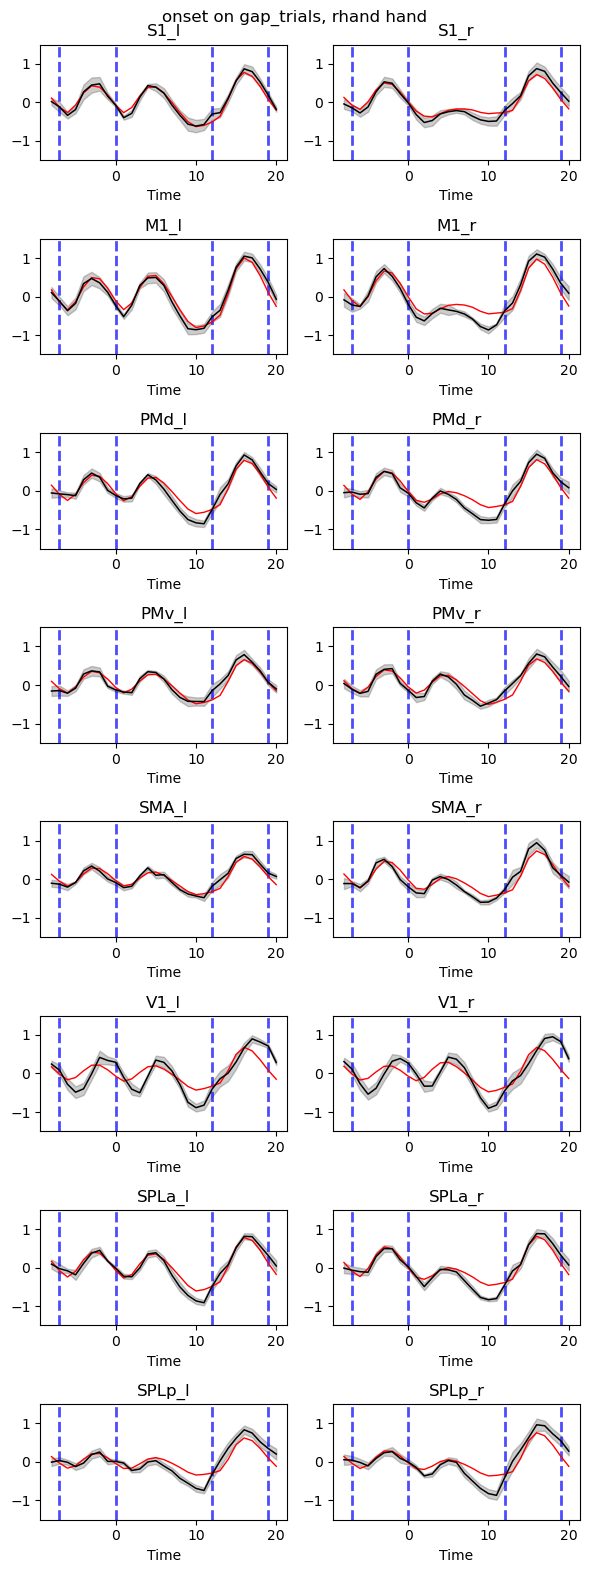

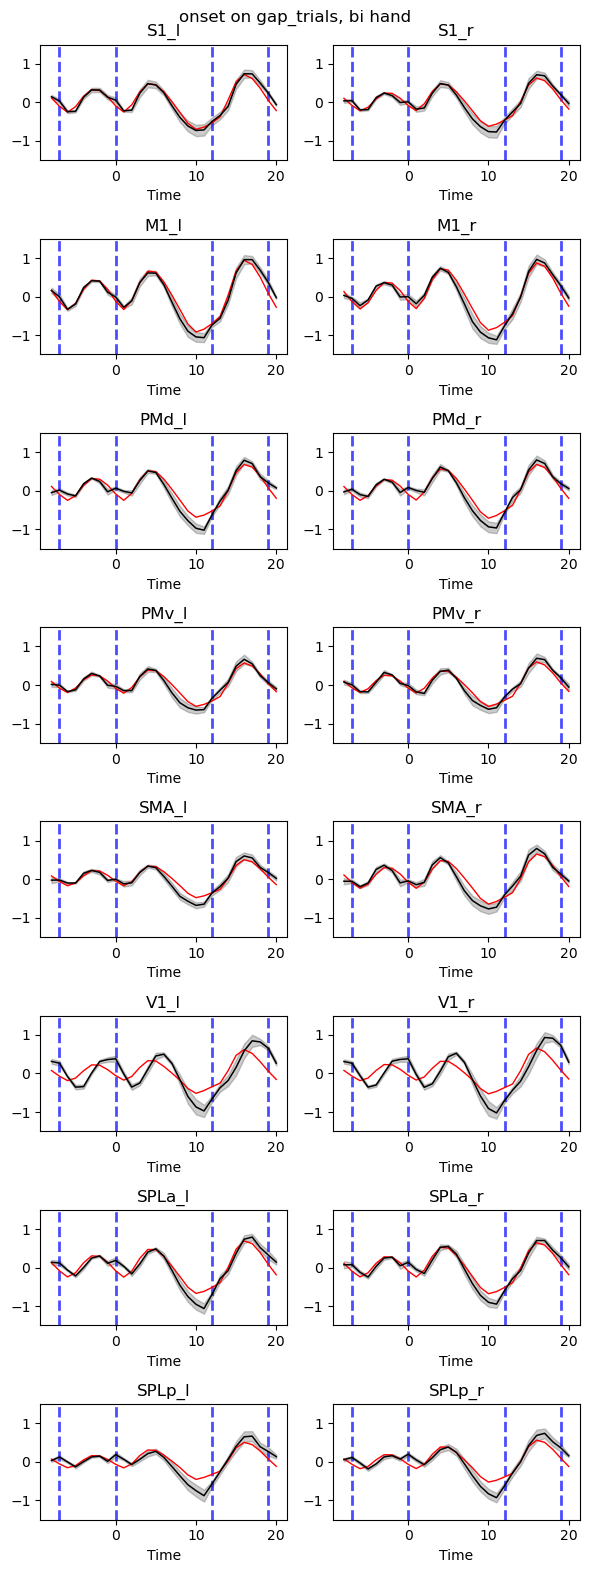

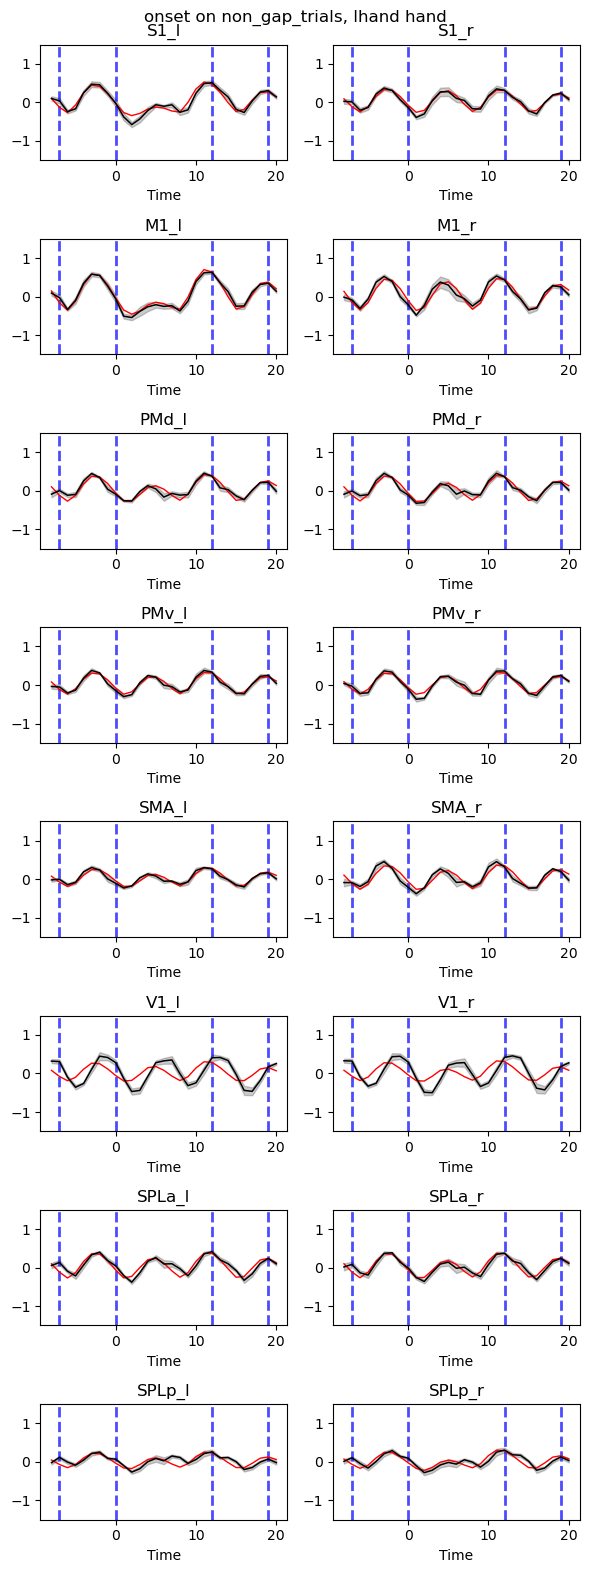

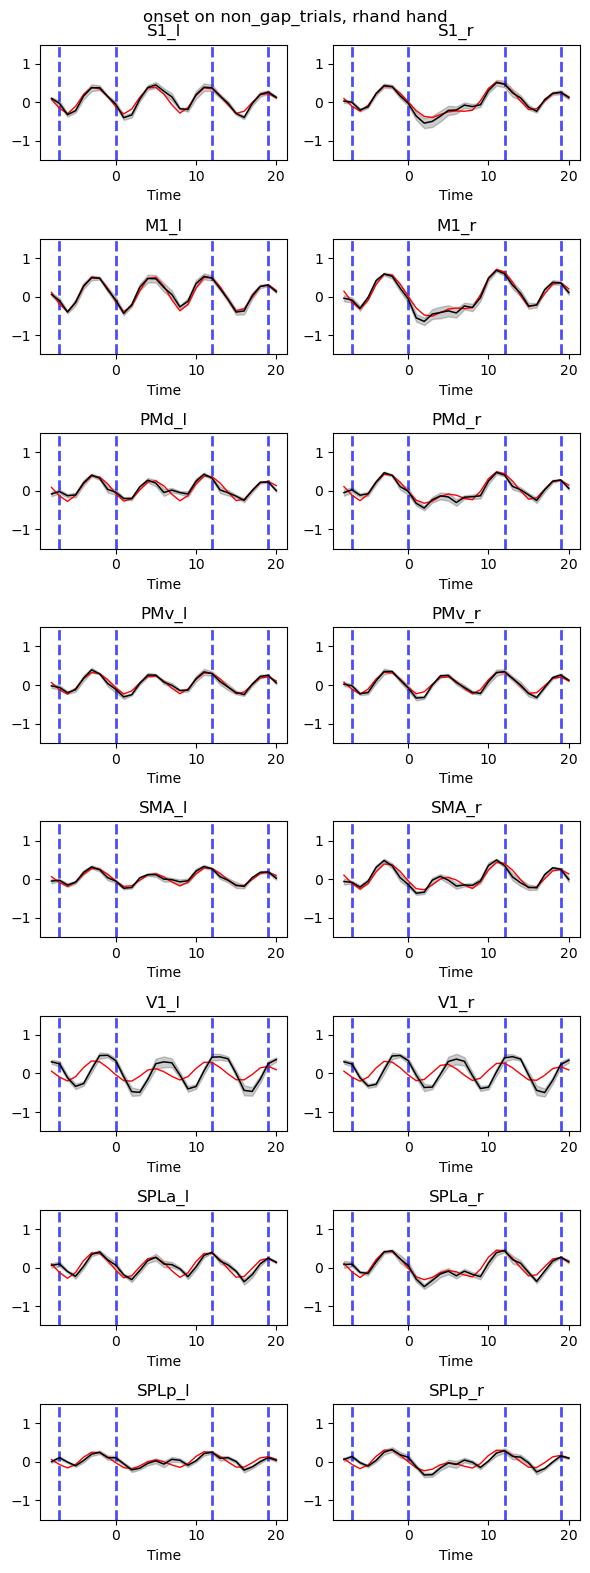

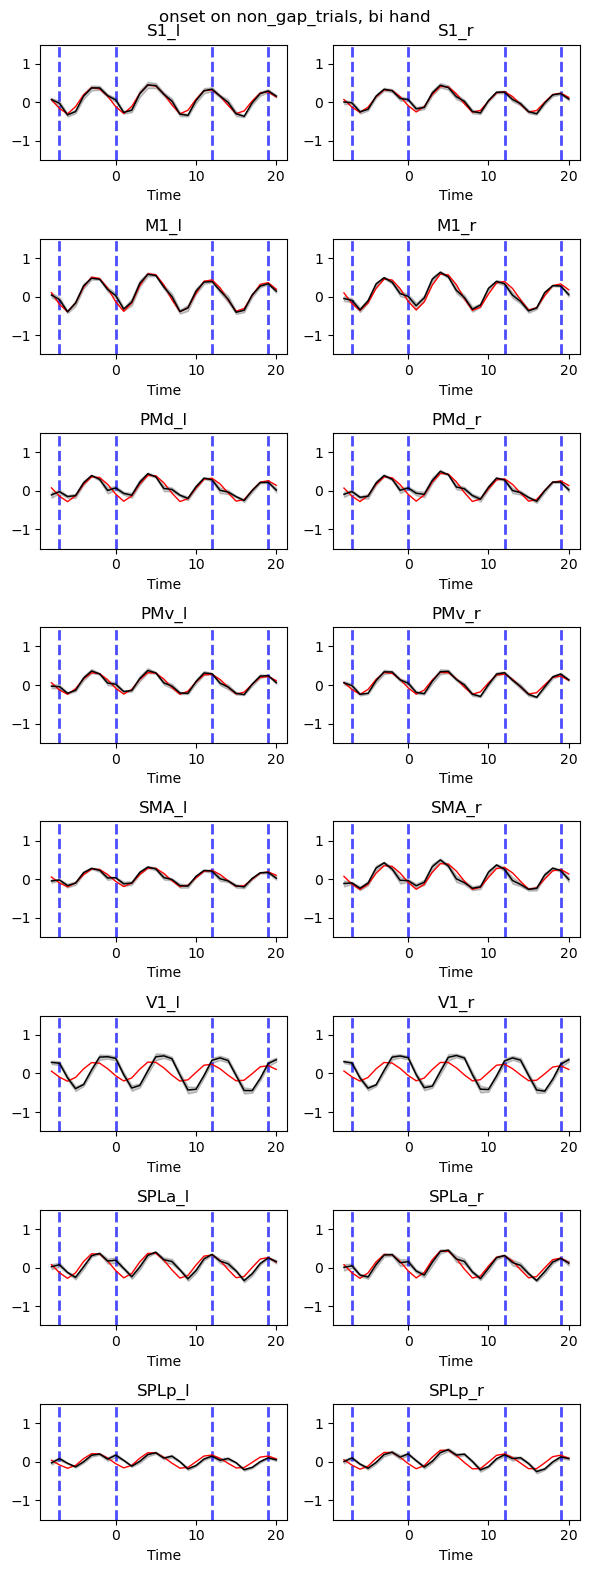

In [20]:
glm = 1
T = pd.read_csv(os.path.join(analysisDir, f'time_series_glm{glm}.csv'))

pre_idx = 8
post_idx = 21

participants = [101,102,103,104,106,107,108]
T = T[T['sn'].isin(participants)].reset_index(drop=True)

conds = ['lhand','rhand','bi']
regions = ['S1_l', 'S1_r', 'M1_l', 'M1_r', 'PMd_l', 'PMd_r',
           'PMv_l', 'PMv_r', 'SMA_l', 'SMA_r', 'V1_l', 'V1_r',
           'SPLa_l', 'SPLa_r', 'SPLp_l', 'SPLp_r']

pinfo = pd.read_table(os.path.join(baseDir, 'participants.tsv'))
TR = pinfo['TR'].values[0]/1000
t = np.arange(-pre_idx, post_idx, TR)

gap_trials = T[T.onset_diff > 10].index - 1
aftergap_trials = T[T.onset_diff > 10].index
non_gap_trials = ~T.index.isin(gap_trials.union(aftergap_trials))
trials = [gap_trials, non_gap_trials]
titles = ['gap_trials', 'non_gap_trials']

for j, trial in enumerate(trials):
    # Select Trials:
    T_gap = T.loc[trial].reset_index(drop=True)
    
    for cond in ['lhand', 'rhand', 'bi']:
        df = T_gap[T_gap['eventtype'].str.contains(cond, na=False)]
        agg_dict = {
                    **{f'y_adj{i}': 'mean' for i in range(len(t))},
                    **{f'y_hat{i}': 'mean' for i in range(len(t))}
                    }
        df = df.groupby(['sn','region_name']).agg(agg_dict).reset_index()
        
        ymin = -1.5
        ymax = 1.5
        n_row = 8
        n_col = 2
        fig, axes = plt.subplots(n_row, n_col, figsize=(6, 16))
        for i,r in enumerate(regions):
            y_adj = df.loc[(df['region_name']==r), [f'y_adj{i}' for i in range(len(t))]].mean().to_list()
            y_adj_sem = df.loc[(df['region_name']==r), [f'y_adj{i}' for i in range(len(t))]].sem().to_list()
            y_hat = df.loc[(df['region_name']==r), [f'y_hat{i}' for i in range(len(t))]].mean().to_list()
            ax = axes[i//n_col, i%n_col]
            ax.vlines([-7,0,12,19], ymin=ymin, ymax=ymax, color='b', ls='--', lw=2, alpha=0.7)
            ax.plot(t, y_hat, color='r', lw=1)
            ax.plot(t, y_adj, color='k', lw=1.1)
            ax.fill_between(t, np.array(y_adj)-np.array(y_adj_sem), np.array(y_adj)+np.array(y_adj_sem), color='k', alpha=0.2)
            ax.set_title(f'{r}')
            ax.set_xlabel('Time')
            ax.set_ylim((ymin, ymax))
        fig.suptitle(f'onset on {titles[j]}, {cond} hand')
        plt.tight_layout()
        plt.savefig(f'../figures/time_series/{titles[j]}_{cond}{glm}.pdf', bbox_inches="tight")
        plt.show()

